In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from tools import *
from h5_tools import *
from fitting_tools import *
from tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
# import pandas as pd
# import glob

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7", "font.size": 14})
plt.rcParams['legend.title_fontsize'] = 'small'

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select runs

In [4]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6']

In [5]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(float(info['Temperature, K']))
    
    else:
        print(filename, "\nFile exists: False")
T = np.array(T)

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

# g2s

In [6]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


In [7]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')

q=0.11 nm$^{-1}$ ferritin_conc_gly_50_6, Transm 100%


Text(0.02, 0.92, 'b')

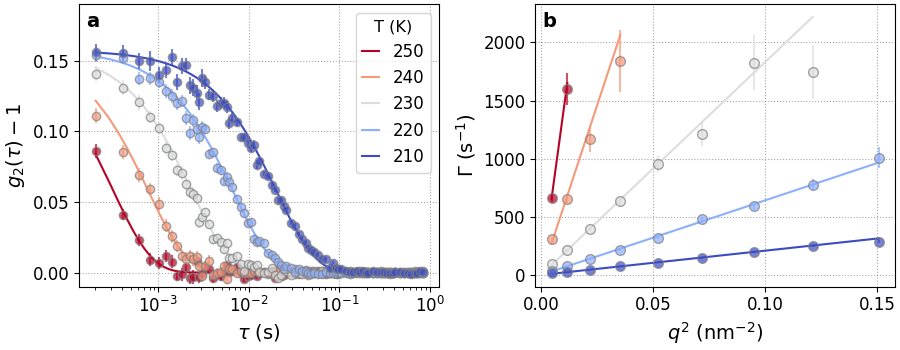

In [8]:
f, (a1,a3) = plt.subplots(1,2, figsize=(9,3.5), constrained_layout=True)

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 1, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            # a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=1, label=f'{T[i]:.0f}')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    # a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'T (K)', fontsize=12, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
print(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$", f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r'$\tau$ (s)')
a1.set_ylabel(r'$g_2(\tau)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
a3.set_xticks(np.arange(0,0.16,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(0.02, 0.92, 'b', fontweight='bold', transform=a3.transAxes)
# plt.savefig('../06-figs/g2s.png', dpi=300)

# diffusion coefficient

### Arrhenius

In [9]:
# load dls data
DLS = load_npz_data('../03-source/DLS_diff_coeff.npz') # D in m^2/s, T in K
DLS['D'] = DLS['D']*1e12

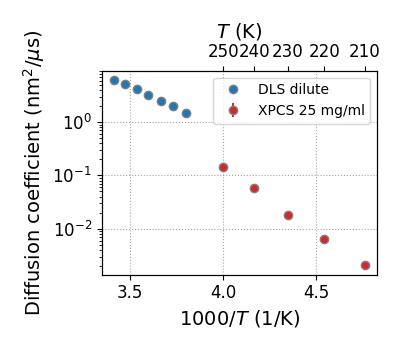

In [25]:
f, ax = plt.subplots(1,1, figsize=(4,3.5), tight_layout=True)
ax2 = ax.twiny()
scale = 1e3

ax.errorbar(scale/T, Ds[0,:], Ds[1,:], ls='', marker='o', mec='gray', c='C3', label='XPCS 25 mg/ml')
# ax.scatter(scale/T, Ds[0,:], label='XPCS 25 mg/ml')
ax.plot(scale/DLS['T'], DLS['D'], label='DLS dilute', c='C0', ls='', marker='o', mec='gray',)

# plot setting
ax.set_xlabel(f'${scale:.0f}/T$ (1/K)')
ax.set_ylabel('Diffusion coefficient (nm$^{{2}}$/${{\mu}}$s)')
# ax.set_ylim([1e-15,1e-11])
ax.legend(fontsize=10)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_yticks(np.arange(1e-3,1.6e-1,0.05))
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/T)
ax2.set_xticklabels(["%.0f" %x for x in T])
ax2.set_xlabel('$T$ (K)', fontsize=14)
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)

### Not Arrhenius